In [19]:
import tensorflow as tf
import os
import numpy as np
from PIL import *
from matplotlib import pyplot as plt


In [2]:
data_dir = './exmaple_image'

In [3]:
filename = os.path.join(data_dir, 'bird.jpg')
out_filename = os.path.join(data_dir, 'bird.tfr')


In [4]:
def get_image_binary(filename):
    image = Image.open(filename)
    image = np.asarray(image, np.uint8)
    shape = np.array(image.shape, np.int32)
    return shape.tobytes(), image.tobytes() # convert image to raw data bytes in the array.

In [5]:
shape, binary_image = get_image_binary(filename)

In [6]:
def write_to_tfrecord(label, shape, binary_image, tfrecord_file):
    """ This example is to write a sample to TFRecord file. If you want to write
    more samples, just use a loop.
    """
    writer = tf.python_io.TFRecordWriter(tfrecord_file)
    # write label, shape, and image content to the TFRecord file
    example = tf.train.Example(features=tf.train.Features(feature={
                'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[label])),
                'shape': tf.train.Feature(bytes_list=tf.train.BytesList(value=[shape])),
                'image':tf.train.Feature(bytes_list=tf.train.BytesList(
                value=[binary_image]))
    }))

    writer.write(example.SerializeToString())
    writer.close()

In [7]:
write_to_tfrecord(shape, shape, binary_image, out_filename)

In [8]:
def read_from_tfrecord(filenames):
    tfrecord_file_queue = tf.train.string_input_producer(filenames, name='queue')
    reader = tf.TFRecordReader()
    _, tfrecord_serialized = reader.read(tfrecord_file_queue)
    # label and image are stored as bytes but could be stored as
    # int64 or float64 values in a serialized tf.Example protobuf.
    tfrecord_features = tf.parse_single_example(tfrecord_serialized,
                        features={
                                    'label': tf.FixedLenFeature([], tf.string),
                                    'shape': tf.FixedLenFeature([], tf.string),
                                    'image': tf.FixedLenFeature([], tf.string),
                                }, name='features')
    
    # image was saved as uint8, so we have to decode as uint8.
    image = tf.decode_raw(tfrecord_features['image'], tf.uint8)
    shape = tf.decode_raw(tfrecord_features['shape'], tf.int32)
    # the image tensor is flattened out, so we have to reconstruct the shape
    image = tf.reshape(image, shape)
    label = tf.cast(tfrecord_features['label'], tf.string)
    
    return label, shape, image

�  �     
[1440 1920    3]
[[[ 56  75  29]
  [ 63  83  34]
  [ 58  76  26]
  ...
  [ 46  56  21]
  [ 46  53  19]
  [ 47  54  20]]

 [[ 60  79  33]
  [ 63  83  34]
  [ 57  75  25]
  ...
  [ 48  62  26]
  [ 48  60  24]
  [ 47  59  21]]

 [[ 57  76  30]
  [ 62  80  32]
  [ 59  77  27]
  ...
  [ 46  64  26]
  [ 42  60  20]
  [ 47  65  25]]

 ...

 [[  4  34   0]
  [  8  36   0]
  [ 12  33   0]
  ...
  [163 199 163]
  [148 183 161]
  [131 167 153]]

 [[  0  30   0]
  [  6  32   0]
  [ 16  36   1]
  ...
  [158 194 158]
  [145 178 157]
  [132 164 151]]

 [[  9  41   0]
  [  8  34   0]
  [ 11  31   0]
  ...
  [149 185 149]
  [139 171 150]
  [129 159 147]]]


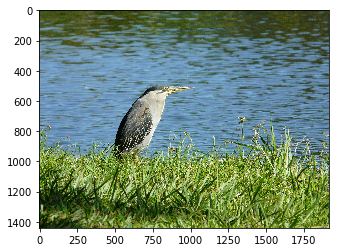

In [20]:
bin_to_read = [os.path.join(data_dir, 'bird.tfr')]
label, shape, image = read_from_tfrecord(bin_to_read)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    print(label.eval())
    print(shape.eval())
    print(image.eval())
    
    img = Image.fromarray(image.eval(), 'RGB')
    
    plt.imshow(image.eval(), interpolation='nearest')
    plt.show()

    #img.show()

    coord.request_stop()
    coord.join(threads)